In [44]:
pwd

'/Users/karlberb/Desktop/Karlberg_work_temp'

In [50]:
ls

7BCD_plot_panels.ipynb               Sample_count_response_summary_2.tsv
7D_predict/                          TCGA_colors_n26_20210228.csv
7D_unkeyed_loop/                     TMP notes.rtf
7_draft_1/                           TMP_cohort_colors_n26_20210228.csv
7_draft_2/                           audit_deep_learning.png
7_draft_3/                           drug_lit_matrices.rtf
BMES/                                drug_response/
Deep Learning Class Audit.png        files_for_export/
Loaner machine notes.docx            prediction_vs_datatype/
Mike Matheny contact.rtf             sample_response_DF_20210805.tsv


In [45]:
%whos

Variable                Type                Data/Info
-----------------------------------------------------
CI_low                  float               0.8737315748812345
CI_lower                list                n=15
CI_range                list                n=15
CI_up                   float               0.8782684251187655
CI_upper                list                n=15
LinearRegression        ABCMeta             <class 'sklearn.linear_mo<...>._base.LinearRegression'>
X_100                   DataFrame               Intercept     Slope\n<...>\n99   0.735239  0.002338
X_only_slope            Series              0     0.000687\n1     0.0<...>me: Slope, dtype: float64
Y_acc                   function            <function Y_acc at 0x7fa901ea1ca0>
accuracy_response       list                n=15
accuracy_response_dct   dict                n=15
actual_full_scores      list                n=15
actual_scores           list                n=0
ax                      AxesSubplot         A

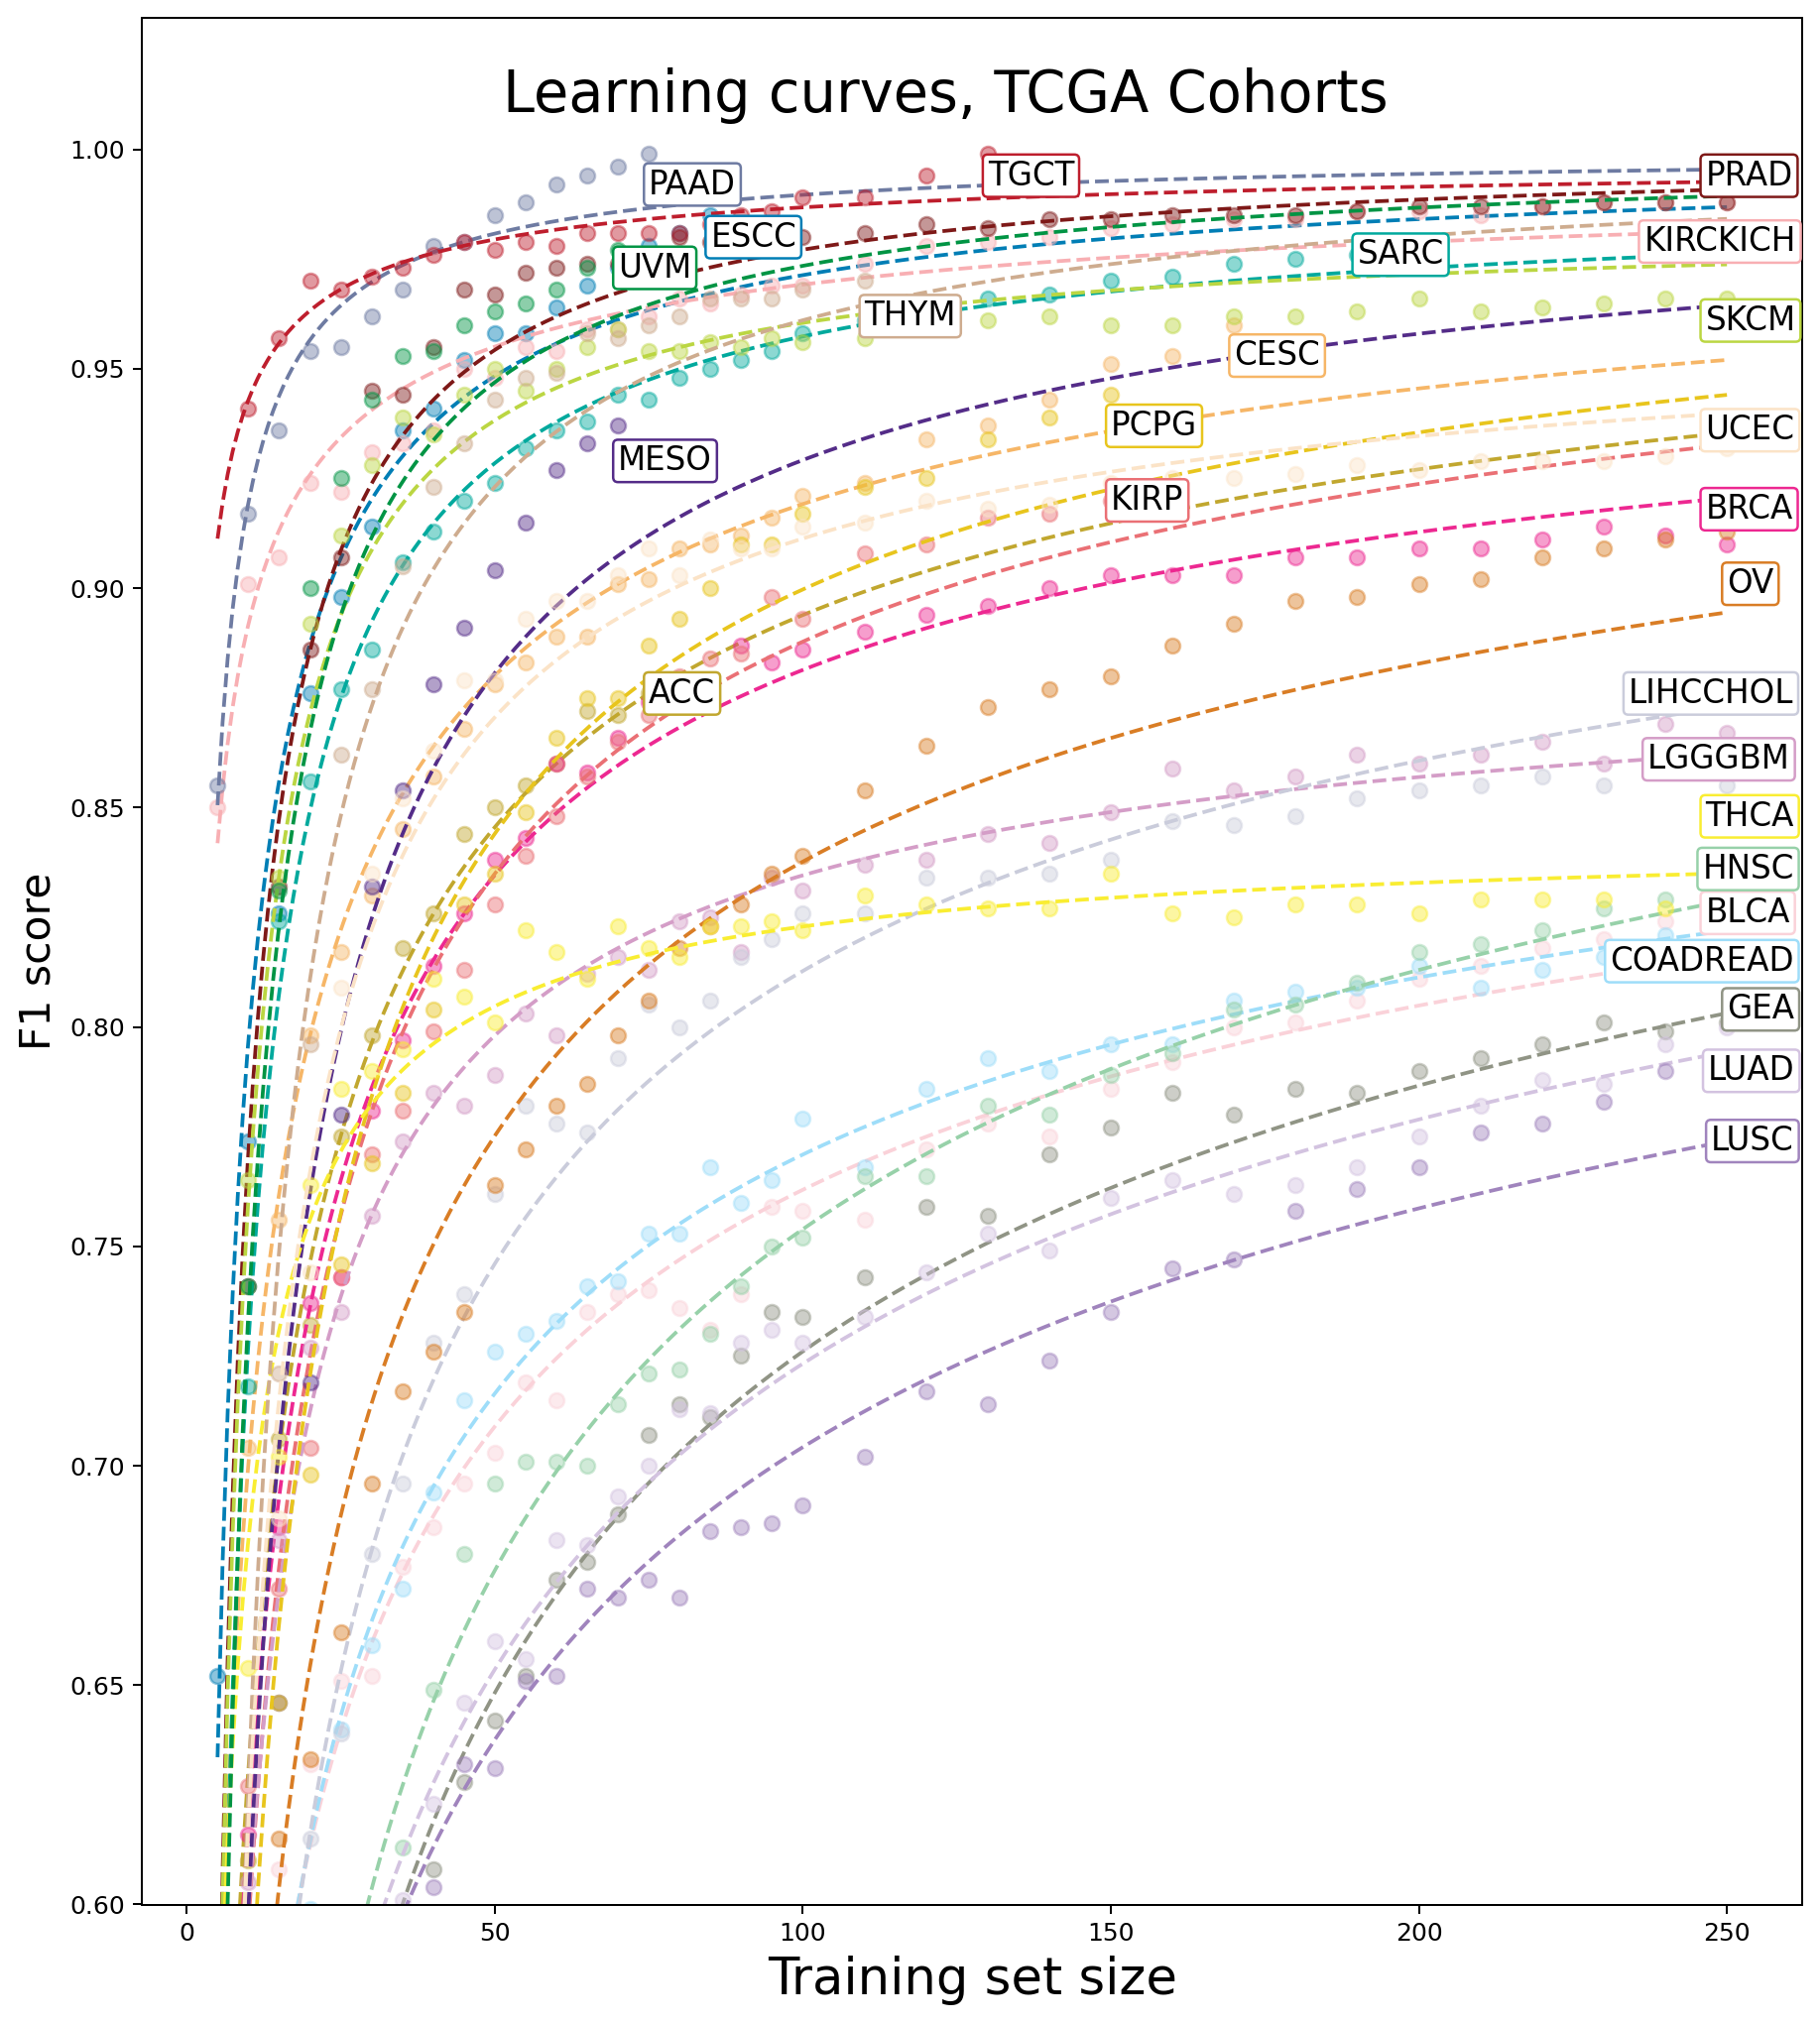

In [52]:
# Panel 7B Main plot, cropped, Labels horizontal
import pandas as pd
import json
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from statistics import mean
colors = pd.read_csv('TCGA_colors_n26_20210228.csv', sep = ',', names = ['Cancer', 'Hexi'])
fig, ax = plt.subplots(figsize = (12,14), dpi = 180)

response_DF = pd.read_csv('sample_response_DF_20210805.tsv', sep = '\t')

def Y_acc(x, a, b, c): # x is sample size
    Y_acc = (1-a)-b*x**c
    return Y_acc

lower = [0,-1000,-1]
upper = [.5,1000,0]


# To do: reset offsets for cropped version
offset = [0,    # ACC
          -.002,    # BLCA
          .008,    # BRCA
          -.007,    # CESC
          -.003,    # COADREAD
          -.005,    # ESCC
          .003,    # GEA
          .003,    # HNSC
          -.009,    # KIRCKICH
          -.0,    # 
          -.006,      # LGGGBM
          .021,      # LIHCCHOL
          -.01,      # LUAD
          -.019,     # LUSC
          -.008,
          -.012, # OV
          -.007,    # PAAD
          -.007,    # PCPG
          .006, # PRAD
          0,
          -.005, # SKCM
          -.005, # TGCT
          .017,  # THCA
          -.008,
          .004, # UCEC
          -.004 ] # UVM

offset_horz = [0,    # ACC
          -3.5,    # BLCA
          -3.5,    # BRCA
          0,    # 
          -19,    # COADREAD
          0,    # ESCC
          .00,    # GEA
          -4,    # HNSC
          -13.5,    # KIRCKICH
          -.0,    # 
          -12.9,      # LGGGBM
          -16,      # LIHCCHOL
          -3.1,      # LUAD
          -2.6,     # LUSC
          -.00,
          -.0, # OV
          0,
          0,
          -3.5, # PRAD
          0,
          -3.5, # SKCM
          -.00, # TGCT
          -3.5,  # THCA
          -.00,
          -3.5, # UCEC
          0]

for idx, cohort in enumerate(response_DF.Cohort):
#     print(idx)
#     break
    accuracy_response_dct = {
        int(k):[i for i in v] for k,v in json.loads(
        response_DF.iloc[idx,1]).items()}
    
    accuracy_response = sorted(accuracy_response_dct.items())
    
    full_samples = []
    full_scores = []
    for i in list(range(0,len(accuracy_response))):
        score = mean(accuracy_response[i][1])
        mean_temp = round(score, 3)
        full_scores.append(mean_temp)
        full_samples.append(accuracy_response[i][0])
#     break
    f, _ = curve_fit(Y_acc, full_samples, full_scores, bounds=[lower,upper])
    color_shard = colors[colors.Cancer == cohort]
    colr = color_shard.iloc[0,1]
    ax.plot(full_samples, full_scores, 'o', c = colr, alpha = .45)
    ax.text(full_samples[-1] + offset_horz[idx],
            full_scores[-1] + offset[idx],
            cohort, fontsize = 13,va='center',
           bbox = dict(facecolor='white', edgecolor=colr, boxstyle='round,pad=0.15'))
    x = np.linspace(5, 250, 300)
    y = Y_acc(x, *f)  
    ax.plot(x, y, '--', color=colr)
fig.suptitle('Learning curves, TCGA Cohorts', y = .86,fontsize = 23)
ax.set_xlabel('Training set size', fontsize = 20.5)
ax.set_ylabel('F1 score', fontsize = 17)
plt.ylim(.6,1.03)
plt.savefig('./7_draft_3/Main_plot_crop_offeset_horz.png',dpi=180)
plt.show()

In [ ]:
for crt in response_DF.Cohort:
    print(crt)

In [33]:
# Begin plot on single 250 sample cohort and prediction cohort
# Panel 7C and B, lower left and right
# Import packeages, read files, set bounds and inverse power function

import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy.optimize import curve_fit
import numpy as np # need for linspace in plot
from statistics import mean
import statistics
import time
import math
import json
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches
import matplotlib.lines as lines
from sklearn.linear_model import LinearRegression
pd.options.display.max_rows = 500

colors = pd.read_csv('TMP_cohort_colors_n26_20210228.csv',
                     sep = ',', skiprows = 1, names = ['Cohort', 'Hexi'])

sample_response_DF = pd.read_csv('sample_response_DF_20210805.tsv',
                                          sep = '\t')

lower = [0,-1000,-1]
upper = [.5,1000,0]

def Y_acc(x, a, b, c): # x is sample size
    Y_acc = (1-a)-b*x**c
    return Y_acc

In [24]:
sample_response_DF.head()

,Cohort,Sample_size_100_accuracies
0,ACC,"{""5"": [0.34285714285714286, 0.6901098901098901..."
1,BLCA,"{""5"": [0.0, 0.8, 0.901010101010101, 0.35606060..."
2,BRCA,"{""5"": [0.4499999999999999, 0.8967032967032967,..."
3,CESC,"{""5"": [0.6329966329966329, 1.0, 0.52, 0.355555..."
4,COADREAD,"{""15"": [0.30416666666666664, 0.713043478260869..."


In [22]:
full_response = [('BLCA', 1),
 ('BRCA', 2),
 ('COADREAD', 4),
 ('GEA', 6),
 ('HNSC', 7),
 ('KIRCKICH', 8),
 ('LGGGBM', 10),
 ('LIHCCHOL', 11),
 ('LUAD', 12),
 ('LUSC', 13),
 ('OV', 15),
 ('PRAD', 18),
 ('SKCM', 20),
 ('THCA', 22),
 ('UCEC', 24)]

In [35]:
full_responseX = [('BLCA', 1)] #13,4 # search fitting ranges and parmeter cuts

In [46]:
full_responseX = [('BRCA', 2)]

In [48]:
full_responseX = [('LGGGBM',10)]

('LGGGBM', 10)
done


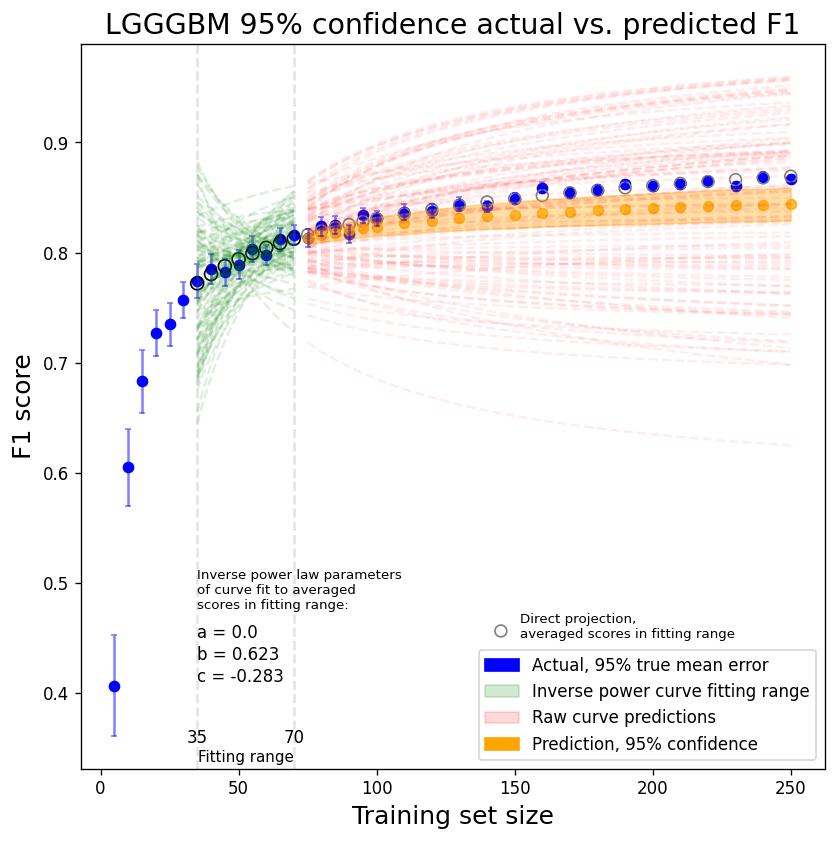

In [49]:
# Full loop [copied from prmtr_bounds.0.1
differences = []
slope_list = []
intercept_list = []
# point_1 = [] # Want actual values, or intercept
# point_2 = []
# intercepts = [] # b in y = mx +b, b = y - mx
fit_list = []
parameter_dict = {}                         # full_responseX devel on single cohort
for idx, cohort_tuple in enumerate(full_responseX): # list of cohorts and indices
    # Make slope table
    # Make paramater table
    # Make lin reg prediction
    # Convert linear regression prediction to paramter value (fix parameter)
    c_prm_dcy_floor = -.95
    c_prm_dcy_ceil = -.01
    
    lower = [0,-1000,-1] # Reset bounds for fitting prediction
    upper = [.5,1000,0]
    
    print(cohort_tuple)
    cohort = cohort_tuple[0]
    cohort_index = cohort_tuple[1]
#     break

    accuracy_response_dct = {
    int(k):[i for i in v] for k,v in json.loads(
        sample_response_DF.iloc[cohort_index,1]).items()} # sample_response_DF_20210805.tsv
    
    accuracy_response = sorted(accuracy_response_dct.items())

    # List of full sample sizes and scores
    full_samples = []
    full_scores = []
    for i in list(range(0,len(accuracy_response))):
        score = mean(accuracy_response[i][1])
        mean_temp = round(score, 3)
        full_scores.append(mean_temp)
        full_samples.append(accuracy_response[i][0])

    # Plot learning curve
    fig, ax = plt.subplots(figsize = (8,8), dpi = 120)
    ax.scatter(full_samples, full_scores, color = 'blue')
    
    # Set fitting region by index
    if cohort not in ['COADREAD', 'HNSC']:
        sample_max = 14 #14 is default, max
        sample_min = 6 #5 is default # BRCA 14,4 and 13,4 is good, 14,7 too
    else:
        sample_max = 13 # 13 is default, max
        sample_min = 5  # 4 is dfault      

    fitting_samples = []
    fitting_scores = []
    fitting_scores_ave = []
    for i in list(range(sample_min, sample_max)): # Iterate fitting region
        score_block = accuracy_response[i][1]
        sample_size = accuracy_response[i][0]
        fitting_samples.append(sample_size)
        fitting_scores.append(score_block) # raw scores for this step
        fitting_scores_ave.append(mean(score_block))

    actual_scores = []
    prediction_samples = [] # * Using this
    for j in list(range(sample_max,len(accuracy_response))):
#         actual_scores.append(accuracy_response[j][1])
        prediction_samples.append(accuracy_response[j][0])

    actual_full_scores = []
    for j in list(range(0,len(accuracy_response))):
        actual_full_scores.append(accuracy_response[j][1])

    CI_upper = []
    CI_lower = []
    n1 = 100
    full_std = [] # list of stdev
    CI_range = []
    for k, score_set in enumerate(actual_full_scores):
        xbar = round(mean(score_set), 3) # yes
        z = 1.96 # 95%
        s = statistics.stdev(score_set) # Yes, all the scores corresponding to this step
        full_std.append(s) # not used
        CI_up = xbar + z * (s/math.sqrt(n1))
        CI_upper.append(CI_up)
        CI_low = xbar - z * (s/math.sqrt(n1))
        CI_lower.append(CI_low)  
        CI_range.append(z * (s/math.sqrt(n1)))

    # Errorbars for sampling error
    ax.errorbar(full_samples,
                full_scores,
                yerr = CI_range, color = 'blue', alpha = .5, fmt=' ',
                capsize = 2)
    
    
    # Set up for slope: use first/last average front curve ************************************************ AVERAGE section
    # also can use first/last or raw or first/last in range of fully fit curve
    # how to use yacc?
    slope = ()
    front_end_mean_params, _ = curve_fit(Y_acc,
                                 fitting_samples,
                                 fitting_scores_ave,
                                    bounds=[lower,upper])
    x_fit_slope = np.linspace(fitting_samples[0], fitting_samples[-1], len(fitting_samples))
    y_fit_slope = Y_acc(x_fit_slope, *front_end_mean_params)
    ax.scatter(x_fit_slope, y_fit_slope, s=60, facecolors='none', edgecolors='black')
    
    parameter_dict[cohort_index] = front_end_mean_params # add to parameter dict
    
    slope_ave = (y_fit_slope[-1] - y_fit_slope[0])/(x_fit_slope[-1] - x_fit_slope[0])
    slope_list.append(slope_ave)
    
    intercept_ave = y_fit_slope[0] - slope_ave * x_fit_slope[0]
    intercept_list.append(intercept_ave)
    
#     fit_list.append(y_fit) # ***** 
    
    # Grey dot projection, based on average curve
    project = Y_acc(prediction_samples, *front_end_mean_params)
    ax.scatter(prediction_samples, project, s=50, facecolors='none', edgecolors='grey')
    
    # Grey dot confidence interval - only one sample for n
    grey_up = []
    grey_low = []
    n=1

    # Set up for prediction              *********************** 100 resamplings, build orange bar
    front_end_parameters = {}
    y_predictions = []
    y_predictions_srs = pd.Series(dtype = 'float64')
    y_std = []
    slopes_100 = []
    intercepts_100 = []
    y_final_100 = []
    orange_vs_grey = []
    down_curves = []
    down_curves_srs = pd.Series(dtype = 'float64')
    for resampling_idx in list(range(0,100)):

        scores_temp = [] # 100 scores for each sample size on restricted front-end portion of curve

        for tuple_n in accuracy_response[sample_min:sample_max]:
            scores_temp.append(tuple_n[1][resampling_idx])

        front_end_param_set_n, _ = curve_fit(Y_acc,
                                 fitting_samples,
                                 scores_temp,
                                    bounds=[lower,upper])
        front_end_parameters[resampling_idx] = front_end_param_set_n

        # Now, plot all 100 front-end fitting curves and compare to actual 
        x_fit = np.linspace(fitting_samples[0], fitting_samples[-1], 50)
        y_fit = Y_acc(x_fit, *front_end_param_set_n)
        ax.plot(x_fit, y_fit, '--', color = 'green', alpha = .12)
        
        slope = (y_fit[-1] - y_fit[0])/(x_fit[-1] - x_fit[0])
        slopes_100.append(slope)
        intercept = y_fit[0] - slope * x_fit[0]
        intercepts_100.append(intercept)
        
        y_predict = Y_acc(prediction_samples, *front_end_param_set_n) # Fit to each param set
        ax.plot(prediction_samples, y_predict, '--', color = 'red', alpha = .07)
        y_predictions.append(y_predict)
        
        y_predictions_srs[str(resampling_idx)] = y_predict

        y_final_100.append(y_predict[-1])
        
        diff = y_predict[0]-y_predict[-1]
        down_curves.append(diff)
    
    slopeDF_100 = pd.DataFrame()
    slopeDF_100['Intercept'] = intercepts_100
    slopeDF_100['Slope'] = slopes_100
    
    # need target: y                                # Regression zone ************************************
    X_100 = slopeDF_100 # dot 4
    reg_100 = LinearRegression().fit(X_100, y_final_100)
    # print coefficient and make prediction by fixing limit table
    y_star4 = reg_100.predict(np.array((intercept_ave, slope_ave)).reshape(1, -1))
    

    X_only_slope = slopeDF_100['Slope'] # 3
    reg_only_slope = LinearRegression().fit(np.array(X_only_slope).reshape(-1,1), y_final_100)
    # print coefficient and make prediction by fixing limit table
    y_star3 = reg_only_slope.predict(np.array(slope_ave).reshape(1, -1))
    
    # Check with mean, use to automate validation (?) 
    mean_predictions = np.mean(y_predictions, axis = 0)
    mpl = list(mean_predictions)
    difference = []
    zip_object = zip(mpl[-5:], full_scores[-5:])
    for list1_i, list2_i in zip_object:
        difference.append(list1_i-list2_i)
    differences.append(mean(difference))
    
    # Orange and grey                               ############### compare predictions and cut inverted curves to push up prediction
    orange_curve = np.mean(y_predictions, axis = 0)

    og_difference = []
    zip_object = zip(orange_curve[-5:], project[-5:]) # check against last five points on two most stable prediction curves
    for list1_i, list2_i in zip_object:
        og_difference.append(list1_i-list2_i)
        
        
    orange_vs_grey.append(mean(og_difference)) # might be unnecessary 
    
    

    y_std = np.std(y_predictions, axis = 0) # Element wise

    pre_CI_upper = []
    pre_CI_lower = []
    n2 = 100 # report this number
    for k, prdt_score_set in enumerate(np.mean(y_predictions, axis = 0)): # 
        xbar = round(prdt_score_set, 3)
        z = 1.96 # 95%
        s = y_std[k]
        pre_CI_up = xbar + z * (s/math.sqrt(n2))
        pre_CI_upper.append(pre_CI_up)
        pre_CI_low = xbar - z * (s/math.sqrt(n2))
        pre_CI_lower.append(pre_CI_low) 

    plt.scatter(prediction_samples, np.mean(y_predictions, axis = 0), alpha = .75,
               color = 'orange')

    ax.fill_between(prediction_samples,
                pre_CI_upper,
                pre_CI_lower,
                alpha = .35, color = 'orange') # Plot orange bar

    plt.title(cohort +
        ' 95% confidence actual vs. predicted F1',
        fontsize = 17)
    ax.set_xlabel('Training set size', fontsize = 15)
    ax.set_ylabel('F1 score', fontsize = 15)
    
    xfit1 = fitting_samples[0]
    xfit2 = fitting_samples[-1]
    ylims = ax.get_ylim()
    y_rng = ylims[1] - ylims[0]
    plt.text(xfit1, ylims[0]+.035 * y_rng,
             str(xfit1), ha = 'center')    
    plt.text((xfit1+xfit2)/2, ylims[0]+.01 * y_rng,
             'Fitting range', ha = 'center', fontsize = 9)
    plt.text(xfit2, ylims[0]+.035 * y_rng,
             str(xfit2), ha = 'center')
    ax.add_artist(lines.Line2D([xfit1, xfit1],
                              [ylims[0], ylims[1]],
                              color = 'grey', linestyle='dashed', alpha = .22))
    ax.add_artist(lines.Line2D([xfit2, xfit2],
                              [ylims[0], ylims[1]],
                              color = 'grey', linestyle='dashed', alpha = .22))
    
    patch_1 = mpatches.Patch(color='blue', label='Actual, 95% true mean error')
    patch_2 = mpatches.Patch(color='green', alpha = .18, label='Inverse power curve fitting range')
    patch_3 = mpatches.Patch(color='red', alpha = .15, label='Raw curve predictions')
    patch_4 = mpatches.Patch(color='orange', label='Prediction, 95% confidence')
    plt.legend(handles=[patch_1, patch_2, patch_3, patch_4], loc = 4)
    
    plt.text(xfit1, ylims[0]+.22 * y_rng, 'Inverse power law parameters\nof curve fit to averaged\nscores in fitting range:',
            fontsize = 8)
    plt.text(xfit1, ylims[0]+.18 * y_rng, 'a = '+str(round(front_end_mean_params[0],3)))
    plt.text(xfit1, ylims[0]+.15 * y_rng, 'b = '+str(round(front_end_mean_params[1],3)))         
    plt.text(xfit1, ylims[0]+.12 * y_rng, 'c = '+str(round(front_end_mean_params[2],3)))
    
    ax.scatter(145, ylims[0]+.19 * y_rng, s=50, facecolors='none', edgecolors='grey')
    ax.text(152, ylims[0]+.18* y_rng, 'Direct projection,\naveraged scores in fitting range', fontsize = 8)

    plt.savefig('./7_draft_3/7C.'+cohort + '.'+
                str(fitting_samples[0])+'.'+
                str(fitting_samples[-1])+
                '.png') # end devel mode

print('done')

In [39]:
ls

7BCD_plot_panels.ipynb               TCGA_colors_n26_20210228.csv
7D_predict/                          TMP_cohort_colors_n26_20210228.csv
7D_unkeyed_loop/                     files_for_export/
7_draft_1/                           prediction_vs_datatype/
7_draft_2/                           sample_response_DF_20210805.tsv
Sample_count_response_summary_2.tsv


In [38]:
pwd

'/Users/karlberb/Desktop/Karlberg_work_temp'

In [ ]:
# Full loop, key toggle
differences = []
slope_list = []
intercept_list = []
# point_1 = [] # Want actual values, or intercept
# point_2 = []
# intercepts = [] # b in y = mx +b, b = y - mx
fit_list = []
parameter_dict = {}                         # full_responseX devel on single cohort
for idx, cohort_tuple in enumerate(full_response): # list of cohorts and indices
    # Make slope table
    # Make paramater table
    # Make lin reg prediction
    # Convert linear regression prediction to paramter value (fix parameter)
    c_prm_dcy_floor = -.95
    c_prm_dcy_ceil = -.01
    
    lower = [0,-1000,-1] # Reset bounds for fitting prediction
    upper = [.5,1000,0]
    
    print(cohort_tuple)
    cohort = cohort_tuple[0]
    cohort_index = cohort_tuple[1]
#     break

    accuracy_response_dct = {
    int(k):[i for i in v] for k,v in json.loads(
        sample_response_DF.iloc[cohort_index,1]).items()} # sample_response_DF_20210805.tsv
    
    accuracy_response = sorted(accuracy_response_dct.items())

    # List of full sample sizes and scores
    full_samples = []
    full_scores = []
    for i in list(range(0,len(accuracy_response))):
        score = mean(accuracy_response[i][1])
        mean_temp = round(score, 3)
        full_scores.append(mean_temp)
        full_samples.append(accuracy_response[i][0])

    # Plot learning curve
    fig, ax = plt.subplots(figsize = (8,8), dpi = 120)
    ax.scatter(full_samples, full_scores, color = 'blue')
    
    # Set fitting region by index
    if cohort not in ['COADREAD', 'HNSC']:
        sample_max = 14 #14 is default, max
        sample_min = 6 #5 is default # BRCA 14,4 and 13,4 is good, 14,7 too
    else:
        sample_max = 13 # 13 is default, max
        sample_min = 5  # 4 is dfault      

    fitting_samples = []
    fitting_scores = []
    fitting_scores_ave = []
    for i in list(range(sample_min, sample_max)): # Iterate fitting region
        score_block = accuracy_response[i][1]
        sample_size = accuracy_response[i][0]
        fitting_samples.append(sample_size)
        fitting_scores.append(score_block) # raw scores for this step
        fitting_scores_ave.append(mean(score_block))

    actual_scores = []
    prediction_samples = [] # * Using this
    for j in list(range(sample_max,len(accuracy_response))):
#         actual_scores.append(accuracy_response[j][1])
        prediction_samples.append(accuracy_response[j][0])

    actual_full_scores = []
    for j in list(range(0,len(accuracy_response))):
        actual_full_scores.append(accuracy_response[j][1])

    CI_upper = []
    CI_lower = []
    n1 = 100
    full_std = [] # list of stdev
    CI_range = []
    for k, score_set in enumerate(actual_full_scores):
        xbar = round(mean(score_set), 3) # yes
        z = 1.96 # 95%
        s = statistics.stdev(score_set) # Yes, all the scores corresponding to this step
        full_std.append(s) # not used
        CI_up = xbar + z * (s/math.sqrt(n1))
        CI_upper.append(CI_up)
        CI_low = xbar - z * (s/math.sqrt(n1))
        CI_lower.append(CI_low)  
        CI_range.append(z * (s/math.sqrt(n1)))

    # Errorbars for sampling error
    ax.errorbar(full_samples,
                full_scores,
                yerr = CI_range, color = 'blue', alpha = .5, fmt=' ',
                capsize = 2)
    
    # Set up for slope: use first/last average front curve ************************************************ AVERAGE section
    slope = ()
    front_end_mean_params, _ = curve_fit(Y_acc,
                                 fitting_samples,
                                 fitting_scores_ave,
                                    bounds=[lower,upper])
    x_fit_slope = np.linspace(fitting_samples[0], fitting_samples[-1], len(fitting_samples))
    y_fit_slope = Y_acc(x_fit_slope, *front_end_mean_params)
    ax.scatter(x_fit_slope, y_fit_slope, s=60, facecolors='none', edgecolors='black')
    
    parameter_dict[cohort_index] = front_end_mean_params # add to parameter dict
    
    slope_ave = (y_fit_slope[-1] - y_fit_slope[0])/(x_fit_slope[-1] - x_fit_slope[0])
    slope_list.append(slope_ave)
    
    intercept_ave = y_fit_slope[0] - slope_ave * x_fit_slope[0]
    intercept_list.append(intercept_ave)
    
    # Grey dot projection, based on average curve
    project = Y_acc(prediction_samples, *front_end_mean_params)
    ax.scatter(prediction_samples, project, s=50, facecolors='none', edgecolors='grey')
    
    # Grey dot confidence interval - only one sample for n
    grey_up = []
    grey_low = []
    n=1

    # Set up for prediction              *********************** 100 resamplings, build orange bar
    front_end_parameters = {}
    y_predictions = []
    y_predictions_srs = pd.Series(dtype = 'float64')
    y_std = []
    slopes_100 = []
    intercepts_100 = []
    y_final_100 = []
    orange_vs_grey = []
    down_curves = []
    down_curves_srs = pd.Series(dtype = 'float64')
    for resampling_idx in list(range(0,100)):

        scores_temp = [] # 100 scores for each sample size on restricted front-end portion of curve

        for tuple_n in accuracy_response[sample_min:sample_max]:
            scores_temp.append(tuple_n[1][resampling_idx])

        front_end_param_set_n, _ = curve_fit(Y_acc,
                                 fitting_samples,
                                 scores_temp,
                                    bounds=[lower,upper])
        front_end_parameters[resampling_idx] = front_end_param_set_n

        # Now, plot all 100 front-end fitting curves and compare to actual 
        x_fit = np.linspace(fitting_samples[0], fitting_samples[-1], 50)
        y_fit = Y_acc(x_fit, *front_end_param_set_n)
        ax.plot(x_fit, y_fit, '--', color = 'green', alpha = .12)
        
        slope = (y_fit[-1] - y_fit[0])/(x_fit[-1] - x_fit[0])
        slopes_100.append(slope)
        intercept = y_fit[0] - slope * x_fit[0]
        intercepts_100.append(intercept)
        
        y_predict = Y_acc(prediction_samples, *front_end_param_set_n) # Fit to each param set
        ax.plot(prediction_samples, y_predict, '--', color = 'red', alpha = .07)
        y_predictions.append(y_predict)
        
        y_predictions_srs[str(resampling_idx)] = y_predict

        y_final_100.append(y_predict[-1])
        
        diff = y_predict[0]-y_predict[-1]
        down_curves.append(diff)
    
    slopeDF_100 = pd.DataFrame()
    slopeDF_100['Intercept'] = intercepts_100
    slopeDF_100['Slope'] = slopes_100
    
    # need target: y                                # Regression zone ************************************
    X_100 = slopeDF_100 # dot 4
    reg_100 = LinearRegression().fit(X_100, y_final_100)
    y_star4 = reg_100.predict(np.array((intercept_ave, slope_ave)).reshape(1, -1))

    X_only_slope = slopeDF_100['Slope'] # 3
    reg_only_slope = LinearRegression().fit(np.array(X_only_slope).reshape(-1,1), y_final_100)
    y_star3 = reg_only_slope.predict(np.array(slope_ave).reshape(1, -1))
    
    mean_predictions = np.mean(y_predictions, axis = 0)
    mpl = list(mean_predictions)
    difference = []
    zip_object = zip(mpl[-5:], full_scores[-5:])
    for list1_i, list2_i in zip_object:
        difference.append(list1_i-list2_i)
    differences.append(mean(difference))
    
    # Orange and grey                               ############### compare predictions and cut inverted curves to push up prediction
    orange_curve = np.mean(y_predictions, axis = 0)

    og_difference = []
    zip_object = zip(orange_curve[-5:], project[-5:]) # check against last five points on two most stable prediction curves
    for list1_i, list2_i in zip_object:
        og_difference.append(list1_i-list2_i)
        
    orange_vs_grey.append(mean(og_difference)) # might be unnecessary 
    
    y_std = np.std(y_predictions, axis = 0) # Element wise

    pre_CI_upper = []
    pre_CI_lower = []
    n2 = 100 # report this number
    for k, prdt_score_set in enumerate(np.mean(y_predictions, axis = 0)): # 
        xbar = round(prdt_score_set, 3)
        z = 1.96 # 95%
        s = y_std[k]
        pre_CI_up = xbar + z * (s/math.sqrt(n2))
        pre_CI_upper.append(pre_CI_up)
        pre_CI_low = xbar - z * (s/math.sqrt(n2))
        pre_CI_lower.append(pre_CI_low) 

    plt.scatter(prediction_samples, np.mean(y_predictions, axis = 0), alpha = .75,
               color = 'orange')

    ax.fill_between(prediction_samples,
                pre_CI_upper,
                pre_CI_lower,
                alpha = .35, color = 'orange') # Plot orange bar

    plt.title(cohort +
        ' 95% confidence actual vs. predicted F1',
        fontsize = 14)
    ax.set_xlabel('Sample size')
    ax.set_ylabel('F1 accuracy')
    
    xfit1 = fitting_samples[0]
    xfit2 = fitting_samples[-1]
    ylims = ax.get_ylim()
    y_rng = ylims[1] - ylims[0]
    plt.text(xfit1, ylims[0]+.035 * y_rng,
             str(xfit1), ha = 'center')    
    plt.text((xfit1+xfit2)/2, ylims[0]+.01 * y_rng,
             'Fitting range', ha = 'center', fontsize = 9)
    plt.text(xfit2, ylims[0]+.035 * y_rng,
             str(xfit2), ha = 'center')
    ax.add_artist(lines.Line2D([xfit1, xfit1],
                              [ylims[0], ylims[1]],
                              color = 'grey', linestyle='dashed', alpha = .22))
    ax.add_artist(lines.Line2D([xfit2, xfit2],
                              [ylims[0], ylims[1]],
                              color = 'grey', linestyle='dashed', alpha = .22))
    
    patch_1 = mpatches.Patch(color='blue', label='Actual, 95% true mean error')
    patch_2 = mpatches.Patch(color='green', alpha = .18, label='Inverse power curve fitting range')
    patch_3 = mpatches.Patch(color='red', alpha = .15, label='Raw curve predictions')
    patch_4 = mpatches.Patch(color='orange', label='Prediction, 95% confidence')
#     plt.legend(handles=[patch_1, patch_2, patch_3, patch_4], loc = 4)
    
    x_key_text = 20
    x_key_shift = 0 # Reduce to move right
    plt.text(xfit1 - x_key_text,
             ylims[0]+.22 * y_rng, 'Inverse power law parameters\nof curve fit to averaged\nscores in fitting range:',
            fontsize = 8)
    plt.text(xfit1 - x_key_shift,
             ylims[0]+.18 * y_rng, 'a = '+str(round(front_end_mean_params[0],3)))
    plt.text(xfit1 - x_key_shift,
             ylims[0]+.15 * y_rng, 'b = '+str(round(front_end_mean_params[1],3)))         
    plt.text(xfit1 - x_key_shift,
             ylims[0]+.12 * y_rng, 'c = '+str(round(front_end_mean_params[2],3)))
    
#     ax.scatter(145, ylims[0]+.19 * y_rng, s=50, facecolors='none', edgecolors='grey')
#     ax.text(152, ylims[0]+.18* y_rng, 'Direct projection,\naveraged scores in fitting range', fontsize = 8)
    plt.savefig('./7D_unkeyed_loop/7CD_unkeyed.'+cohort + '.'+
                str(fitting_samples[0])+'.'+
                str(fitting_samples[-1])+
                '.png') # end devel mode

print('done')

In [34]:
sample_response_DF.head(26)

,Cohort,Sample_size_100_accuracies
0,ACC,"{""5"": [0.34285714285714286, 0.6901098901098901..."
1,BLCA,"{""5"": [0.0, 0.8, 0.901010101010101, 0.35606060..."
2,BRCA,"{""5"": [0.4499999999999999, 0.8967032967032967,..."
3,CESC,"{""5"": [0.6329966329966329, 1.0, 0.52, 0.355555..."
4,COADREAD,"{""15"": [0.30416666666666664, 0.713043478260869..."
5,ESCC,"{""5"": [0.6901098901098901, 0.901010101010101, ..."
6,GEA,"{""5"": [0.0, 0.5333333333333333, 0.072727272727..."
7,HNSC,"{""15"": [0.33015873015873015, 0.530275606746194..."
8,KIRCKICH,"{""5"": [0.8, 1.0, 0.9333333333333333, 0.7777777..."
9,KIRP,"{""15"": [0.6953333333333334, 0.7443850267379678..."


In [ ]:
partial_response = []
for i, cohort in sample_response_DF:
    

In [42]:
full_response_predict = [('ACC', 0)]

In [35]:
full_response

[('BLCA', 1),
 ('BRCA', 2),
 ('COADREAD', 4),
 ('GEA', 6),
 ('HNSC', 7),
 ('KIRCKICH', 8),
 ('LGGGBM', 10),
 ('LIHCCHOL', 11),
 ('LUAD', 12),
 ('LUSC', 13),
 ('OV', 15),
 ('PRAD', 18),
 ('SKCM', 20),
 ('THCA', 22),
 ('UCEC', 24)]

In [36]:
full_response_predict = [('ACC', 0),
                        ('CESC', 3),
                        ('ESCC', 5),
                        ('KIRP', 9),
                        ('MESO', 14),
                        ('PAAD', 16),
                        ('PCPG', 17),
                        ('SARC', 19),
                        ('TGCT', 21),
                        ('THYM', 23),
                        ('UVM', 25),]

In [30]:
accuracy_response # List of tuples, raw data

[(5,
  [0.34285714285714286,
   0.6901098901098901,
   0.34285714285714286,
   0.4,
   0.48351648351648346,
   0.4,
   0.07272727272727272,
   0.2285714285714286,
   0.5648148148148148,
   0.5392561983471075,
   0.64,
   0.1142857142857143,
   0.26666666666666666,
   0.4,
   0.8967032967032967,
   0.32727272727272727,
   0.8,
   0.27692307692307694,
   0.6901098901098901,
   0.4257142857142858,
   0.37037037037037035,
   0.4,
   0.898989898989899,
   0.6,
   0.2,
   0.36923076923076914,
   0.4,
   1.0,
   0.64,
   0.6666666666666666,
   0.4,
   0.6885714285714286,
   0.32727272727272727,
   0.4499999999999999,
   0.32,
   0.4,
   0.4,
   0.17777777777777778,
   0.3,
   0.4615384615384615,
   0.1,
   0.7030303030303029,
   0.46984126984126984,
   0.45454545454545453,
   0.28888888888888886,
   0.4666666666666666,
   0.21818181818181817,
   0.35,
   0.2803030303030303,
   0.6628571428571428,
   0.8967032967032967,
   0.4499999999999999,
   0.32,
   0.24000000000000005,
   0.1090909090909

In [31]:
prediction_samples

[75]

In [32]:
len(accuracy_response)

15

('ACC', 0)
done


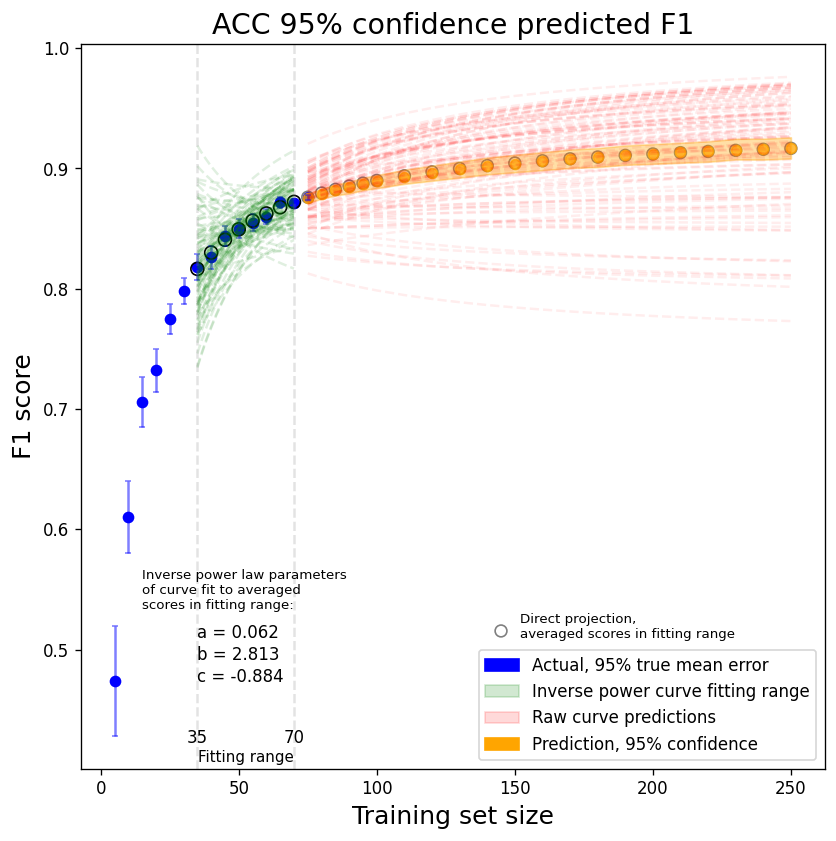

In [43]:
# Predict, key toggle on
differences = []
slope_list = []
intercept_list = []
# point_1 = [] # Want actual values, or intercept
# point_2 = []
# intercepts = [] # b in y = mx +b, b = y - mx
fit_list = []
parameter_dict = {}                         # full_response_predict devel on single cohort
for idx, cohort_tuple in enumerate(full_response_predict): # list of cohorts and indices
    # Make slope table
    # Make paramater table
    # Make lin reg prediction
    # Convert linear regression prediction to paramter value (fix parameter)
    c_prm_dcy_floor = -.95
    c_prm_dcy_ceil = -.01
    
    lower = [0,-1000,-1] # Reset bounds for fitting prediction
    upper = [.5,1000,0]
    
    print(cohort_tuple)
    cohort = cohort_tuple[0]
    cohort_index = cohort_tuple[1]
#     break

    accuracy_response_dct = {
    int(k):[i for i in v] for k,v in json.loads(
        sample_response_DF.iloc[cohort_index,1]).items()} # sample_response_DF_20210805.tsv
    
    accuracy_response = sorted(accuracy_response_dct.items())

    # List of full sample sizes and scores
    full_samples = []
    full_scores = []
    for i in list(range(0,len(accuracy_response))):
        score = mean(accuracy_response[i][1])
        mean_temp = round(score, 3)
        full_scores.append(mean_temp)
        full_samples.append(accuracy_response[i][0])

    # Plot learning curve
    fig, ax = plt.subplots(figsize = (8,8), dpi = 120)
    ax.scatter(full_samples, full_scores, color = 'blue')
    
    # Set fitting region by index
    if cohort not in ['COADREAD', 'HNSC']:
        sample_max = 14 #14 is default, max
        sample_min = 6 #5 is default # BRCA 14,4 and 13,4 is good, 14,7 too
    else:
        sample_max = 13 # 13 is default, max
        sample_min = 5  # 4 is dfault      

    fitting_samples = []
    fitting_scores = []
    fitting_scores_ave = []
    for i in list(range(sample_min, sample_max)): # Iterate fitting region
        score_block = accuracy_response[i][1]
        sample_size = accuracy_response[i][0]
        fitting_samples.append(sample_size)
        fitting_scores.append(score_block) # raw scores for this step
        fitting_scores_ave.append(mean(score_block))

    actual_scores = []
    prediction_samples = [75,80,85,90,95,100,
                         110,120,130,140,150,160,170,180,
                         190,200,210,220,230,240,250] # * Need to go to 250, SA
    
    actual_full_scores = []
    for j in list(range(0,len(accuracy_response))):
        actual_full_scores.append(accuracy_response[j][1])

    CI_upper = []
    CI_lower = []
    n1 = 100
    full_std = [] # list of stdev
    CI_range = []
    for k, score_set in enumerate(actual_full_scores):
        xbar = round(mean(score_set), 3) # yes
        z = 1.96 # 95%
        s = statistics.stdev(score_set) # Yes, all the scores corresponding to this step
        full_std.append(s) # not used
        CI_up = xbar + z * (s/math.sqrt(n1))
        CI_upper.append(CI_up)
        CI_low = xbar - z * (s/math.sqrt(n1))
        CI_lower.append(CI_low)  
        CI_range.append(z * (s/math.sqrt(n1)))

    # Errorbars for sampling error
    ax.errorbar(full_samples,
                full_scores,
                yerr = CI_range, color = 'blue', alpha = .5, fmt=' ',
                capsize = 2)
    
    # Set up for slope: use first/last average front curve ************************************************ AVERAGE section
    slope = ()
    front_end_mean_params, _ = curve_fit(Y_acc,
                                 fitting_samples,
                                 fitting_scores_ave,
                                    bounds=[lower,upper])
    x_fit_slope = np.linspace(fitting_samples[0], fitting_samples[-1], len(fitting_samples))
    y_fit_slope = Y_acc(x_fit_slope, *front_end_mean_params)
    ax.scatter(x_fit_slope, y_fit_slope, s=60, facecolors='none', edgecolors='black')
    
    parameter_dict[cohort_index] = front_end_mean_params # add to parameter dict
    
    slope_ave = (y_fit_slope[-1] - y_fit_slope[0])/(x_fit_slope[-1] - x_fit_slope[0])
    slope_list.append(slope_ave)
    
    intercept_ave = y_fit_slope[0] - slope_ave * x_fit_slope[0]
    intercept_list.append(intercept_ave)
    
    # Grey dot projection, based on average curve
    project = Y_acc(prediction_samples, *front_end_mean_params)
    ax.scatter(prediction_samples, project, s=50, facecolors='none', edgecolors='grey')
    
    # Grey dot confidence interval - only one sample for n
    grey_up = []
    grey_low = []
    n=1

    # Set up for prediction              *********************** 100 resamplings, build orange bar
    front_end_parameters = {}
    y_predictions = []
    y_predictions_srs = pd.Series(dtype = 'float64')
    y_std = []
    slopes_100 = []
    intercepts_100 = []
    y_final_100 = []
    orange_vs_grey = []
    down_curves = []
    down_curves_srs = pd.Series(dtype = 'float64')
    for resampling_idx in list(range(0,100)):

        scores_temp = [] # 100 scores for each sample size on restricted front-end portion of curve

        for tuple_n in accuracy_response[sample_min:sample_max]:
            scores_temp.append(tuple_n[1][resampling_idx])

        front_end_param_set_n, _ = curve_fit(Y_acc,
                                 fitting_samples,
                                 scores_temp,
                                    bounds=[lower,upper])
        front_end_parameters[resampling_idx] = front_end_param_set_n

        # Now, plot all 100 front-end fitting curves and compare to actual 
        x_fit = np.linspace(fitting_samples[0], fitting_samples[-1], 50)
        y_fit = Y_acc(x_fit, *front_end_param_set_n)
        ax.plot(x_fit, y_fit, '--', color = 'green', alpha = .12)
        
        slope = (y_fit[-1] - y_fit[0])/(x_fit[-1] - x_fit[0])
        slopes_100.append(slope)
        intercept = y_fit[0] - slope * x_fit[0]
        intercepts_100.append(intercept)
        
        y_predict = Y_acc(prediction_samples, *front_end_param_set_n) # Fit to each param set
        ax.plot(prediction_samples, y_predict, '--', color = 'red', alpha = .07)
        y_predictions.append(y_predict)
        
        y_predictions_srs[str(resampling_idx)] = y_predict

        y_final_100.append(y_predict[-1])
        
        diff = y_predict[0]-y_predict[-1]
        down_curves.append(diff)
    
    slopeDF_100 = pd.DataFrame()
    slopeDF_100['Intercept'] = intercepts_100
    slopeDF_100['Slope'] = slopes_100
    
    # need target: y                                # Regression zone ************************************
    X_100 = slopeDF_100 # dot 4
    reg_100 = LinearRegression().fit(X_100, y_final_100)
    y_star4 = reg_100.predict(np.array((intercept_ave, slope_ave)).reshape(1, -1))

    X_only_slope = slopeDF_100['Slope'] # 3
    reg_only_slope = LinearRegression().fit(np.array(X_only_slope).reshape(-1,1), y_final_100)
    y_star3 = reg_only_slope.predict(np.array(slope_ave).reshape(1, -1))
    
    mean_predictions = np.mean(y_predictions, axis = 0)
    mpl = list(mean_predictions)
    difference = []
    zip_object = zip(mpl[-5:], full_scores[-5:])
    for list1_i, list2_i in zip_object:
        difference.append(list1_i-list2_i)
    differences.append(mean(difference))
    
    # Orange and grey                               ############### compare predictions and cut inverted curves to push up prediction
    orange_curve = np.mean(y_predictions, axis = 0)

    og_difference = []
    zip_object = zip(orange_curve[-5:], project[-5:]) # check against last five points on two most stable prediction curves
    for list1_i, list2_i in zip_object:
        og_difference.append(list1_i-list2_i)
        
    orange_vs_grey.append(mean(og_difference)) # might be unnecessary 
    
    y_std = np.std(y_predictions, axis = 0) # Element wise

    pre_CI_upper = []
    pre_CI_lower = []
    n2 = 100 # report this number
    for k, prdt_score_set in enumerate(np.mean(y_predictions, axis = 0)): # 
        xbar = round(prdt_score_set, 3)
        z = 1.96 # 95%
        s = y_std[k]
        pre_CI_up = xbar + z * (s/math.sqrt(n2))
        pre_CI_upper.append(pre_CI_up)
        pre_CI_low = xbar - z * (s/math.sqrt(n2))
        pre_CI_lower.append(pre_CI_low) 

    plt.scatter(prediction_samples, np.mean(y_predictions, axis = 0), alpha = .75,
               color = 'orange')

    ax.fill_between(prediction_samples,
                pre_CI_upper,
                pre_CI_lower,
                alpha = .35, color = 'orange') # Plot orange bar

    plt.title(cohort +
        ' 95% confidence predicted F1',
        fontsize = 17)
    ax.set_xlabel('Training set size', fontsize = 15)
    ax.set_ylabel('F1 score', fontsize = 15)
    
    xfit1 = fitting_samples[0]
    xfit2 = fitting_samples[-1]
    ylims = ax.get_ylim()
    y_rng = ylims[1] - ylims[0]
    plt.text(xfit1, ylims[0]+.035 * y_rng,
             str(xfit1), ha = 'center')    
    plt.text((xfit1+xfit2)/2, ylims[0]+.01 * y_rng,
             'Fitting range', ha = 'center', fontsize = 9)
    plt.text(xfit2, ylims[0]+.035 * y_rng,
             str(xfit2), ha = 'center')
    ax.add_artist(lines.Line2D([xfit1, xfit1],
                              [ylims[0], ylims[1]],
                              color = 'grey', linestyle='dashed', alpha = .22))
    ax.add_artist(lines.Line2D([xfit2, xfit2],
                              [ylims[0], ylims[1]],
                              color = 'grey', linestyle='dashed', alpha = .22))
    
    patch_1 = mpatches.Patch(color='blue', label='Actual, 95% true mean error')
    patch_2 = mpatches.Patch(color='green', alpha = .18, label='Inverse power curve fitting range')
    patch_3 = mpatches.Patch(color='red', alpha = .15, label='Raw curve predictions')
    patch_4 = mpatches.Patch(color='orange', label='Prediction, 95% confidence')
    plt.legend(handles=[patch_1, patch_2, patch_3, patch_4], loc = 4)
    
    x_key_text = 20
    x_key_shift = 0 # Reduce to move right
    plt.text(xfit1 - x_key_text,
             ylims[0]+.22 * y_rng, 'Inverse power law parameters\nof curve fit to averaged\nscores in fitting range:',
            fontsize = 8)
    plt.text(xfit1 - x_key_shift,
             ylims[0]+.18 * y_rng, 'a = '+str(round(front_end_mean_params[0],3)))
    plt.text(xfit1 - x_key_shift,
             ylims[0]+.15 * y_rng, 'b = '+str(round(front_end_mean_params[1],3)))         
    plt.text(xfit1 - x_key_shift,
             ylims[0]+.12 * y_rng, 'c = '+str(round(front_end_mean_params[2],3)))
    
    ax.scatter(145, ylims[0]+.19 * y_rng, s=50, facecolors='none', edgecolors='grey')
    ax.text(152, ylims[0]+.18* y_rng,
        'Direct projection,\naveraged scores in fitting range', fontsize = 8)
    plt.savefig('./7_draft_2/7D.'+cohort + '.'+
                str(fitting_samples[0])+'.'+
                str(fitting_samples[-1])+
                '.png') # end devel mode

print('done')

In [ ]:
# Notes on reproducibility
# Coeffs one and two cut
# y_hat cut, etc.

In [2]:
# Install notes:
!pip3 install scikit-learn

     |████████████████████████████████| 7.2 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 2.1 MB/s eta 0:00:01
